In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons


In [2]:
def generate_moons(n_samples=1000, noise=0.1):
    X, _ = make_moons(n_samples=n_samples, noise=noise)
    X = X.astype(np.float32)
    return torch.tensor(X)


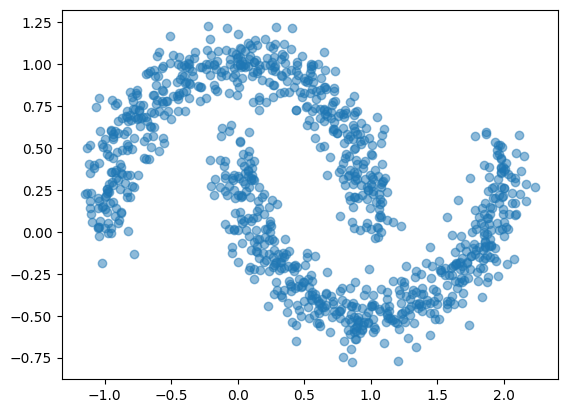

In [3]:
data_samples = generate_moons(n_samples=1000)
plt.scatter(data_samples[:, 0], data_samples[:, 1], alpha=0.5)

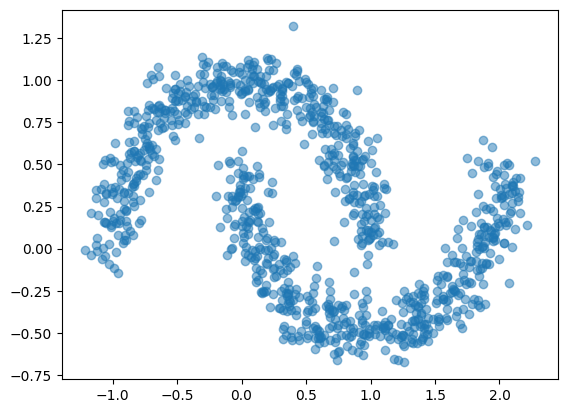

In [6]:
data_samples = generate_moons(n_samples=1000)
plt.scatter(data_samples[:, 0], data_samples[:, 1], alpha=0.5)

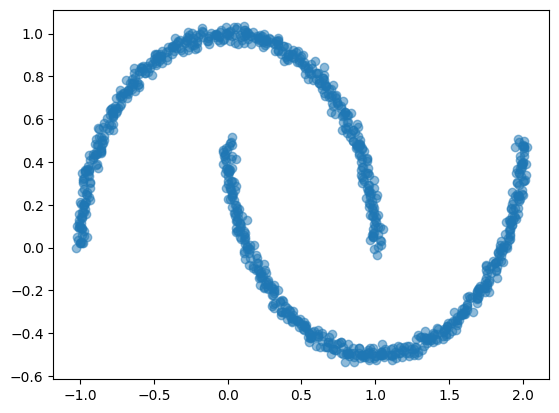

In [4]:
data_samples = generate_moons(n_samples=1000, noise=0.02)
plt.scatter(data_samples[:, 0], data_samples[:, 1], alpha=0.5)

In [5]:
def simple_mlp(in_dim, hidden_dim, out_dim):
    return nn.Sequential(
        nn.Linear(in_dim+1, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, out_dim)
    )
    

In [69]:
print(T)

100


In [3]:

class DDPM(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=128, out_dim=2, T=100, mlp_model=None):

        super().__init__()
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.T = T
        self.betas = torch.linspace(0.0001, 0.02, T).to(device)  
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0).to(device) 
        self.model =mlp_model if mlp_model else simple_mlp(in_dim, hidden_dim, out_dim)
        self.model.to(device)
        self.device= device
       
    def forward_diffusion(self, x0, t):
        noise = torch.randn_like(x0)
        mean = torch.sqrt(self.alphas_cumprod[t])[:, None] * x0
        std = torch.sqrt(1 - self.alphas_cumprod[t])[:, None]
        return mean + std * noise, noise
    
    def get_eps_from_model(self, x, t):
        # t is a number
        with torch.no_grad():
            return self.model(torch.cat((x, torch.full((x.shape[0], 1), t / self.T, device=self.device)), dim=1))

    def get_eps_from_model_batch(self, x, t):
        # t in a tensor 
        with torch.no_grad():
            t = t / self.T
            t = t.float().view(-1, 1)  # Reshape t to be a column vector
            # Concatenate x and t along the feature dimension
            return self.model(torch.cat((x, t), dim=1))

    def compute_mu(self, x, eps, t):
        return (x - self.betas[t] / torch.sqrt(1 - self.alphas_cumprod[t]) * eps) / torch.sqrt(self.alphas[t])

    def compute_mu_batch(self, x, eps, t):
        t = t.long()
        betas_t = self.betas[t].view(-1, 1)
        alphas_cumprod_t = self.alphas_cumprod[t].view(-1, 1)
        alphas_t = self.alphas[t].view(-1, 1)
        mu = (x - betas_t / torch.sqrt(1 - alphas_cumprod_t) * eps) / torch.sqrt(alphas_t)
        return mu

    def sample(self, n_samples=1000):
        x = torch.randn(n_samples, 2, device=self.device)
        for t in reversed(range(self.T)):
            z = torch.randn_like(x, device=self.device) if t > 0 else 0
            eps = self.get_eps_from_model(x, t)
            mu = self.compute_mu(x, eps, t)
            x = mu + torch.sqrt(self.betas[t]) * z
        return x.detach().cpu().numpy()

    def get_x0_from_xt(self, xt, t):
        """Extracts x0 (clean sample) from xt using the estimated noise epsilon."""
        t = t.long()
        
        # Retrieve noise estimate (eps) from the model
        eps = self.get_eps_from_model_batch(xt, t)

        # Get alphas_cumprod for the given timesteps
        alphas_cumprod_t = torch.tensor(self.alphas_cumprod[t]).view(-1, 1)  # Shape: (batch_size, 1)

        # Compute x0 using the formula
        x0 = (xt - torch.sqrt(1 - alphas_cumprod_t) * eps) / torch.sqrt(alphas_cumprod_t)
        
        return x0




def train_ddpm(ddpm_model, dataset, epochs=5000, batch_size=128, lr=3e-2, n_samples=5000, noise_dataset=0.1):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    optimizer = optim.Adam(ddpm_model.model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    ddpm_model.to(device)
    dataset = dataset.to(device)
    for epoch in range(epochs):
        idx = torch.randint(0, dataset.shape[0], (batch_size,))
        x0 = dataset[idx]
        t = np.random.randint(0, ddpm_model.T, (batch_size,))
        xt, noise = ddpm_model.forward_diffusion(x0, t)
        noise_pred = ddpm_model.model(torch.cat((xt, torch.tensor(t[:, None], device=device) / ddpm_model.T), dim=1))
        loss = criterion(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.0332
Epoch 500, Loss: 0.5948
Epoch 1000, Loss: 0.4923
Epoch 1500, Loss: 0.4758
Epoch 2000, Loss: 0.5675
Epoch 2500, Loss: 0.4395
Epoch 3000, Loss: 0.5078
Epoch 3500, Loss: 0.3989
Epoch 4000, Loss: 0.5247
Epoch 4500, Loss: 0.4850
Epoch 5000, Loss: 0.5421
Epoch 5500, Loss: 0.5238
Epoch 6000, Loss: 0.5138
Epoch 6500, Loss: 0.6442
Epoch 7000, Loss: 0.5692
Epoch 7500, Loss: 0.6715
Epoch 8000, Loss: 0.6083
Epoch 8500, Loss: 0.4967
Epoch 9000, Loss: 0.3987
Epoch 9500, Loss: 0.4319
Epoch 10000, Loss: 0.5762
Epoch 10500, Loss: 0.5044
Epoch 11000, Loss: 0.4904
Epoch 11500, Loss: 0.5437
Epoch 12000, Loss: 0.5279
Epoch 12500, Loss: 0.5567
Epoch 13000, Loss: 0.4930
Epoch 13500, Loss: 0.4991
Epoch 14000, Loss: 0.4960
Epoch 14500, Loss: 0.5015
Epoch 15000, Loss: 0.5028
Epoch 15500, Loss: 0.5221
Epoch 16000, Loss: 0.4181
Epoch 16500, Loss: 0.5679
Epoch 17000, Loss: 0.4606
Epoch 17500, Loss: 0.4855
Epoch 18000, Loss: 0.4326
Epoch 18500, Loss: 0.4306
Epoch 19000, Loss: 0.5095
Epoch 1950

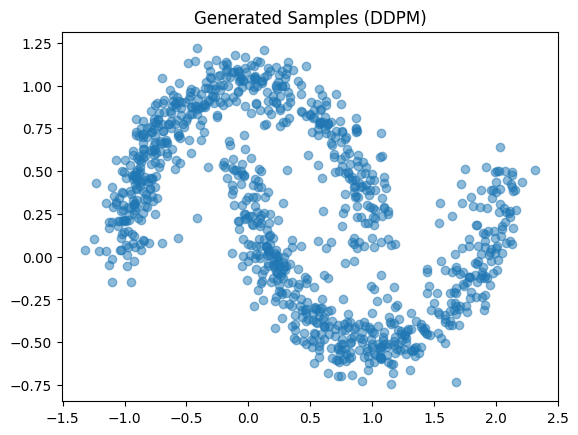

In [75]:
ddpm = DDPM()
train_ddpm(ddpm, epochs=20000, batch_size=128, lr=1e-3, n_samples=5000)
samples = ddpm.sample()
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title("Generated Samples (DDPM)")
plt.show()

x0.shape=torch.Size([1024, 2])


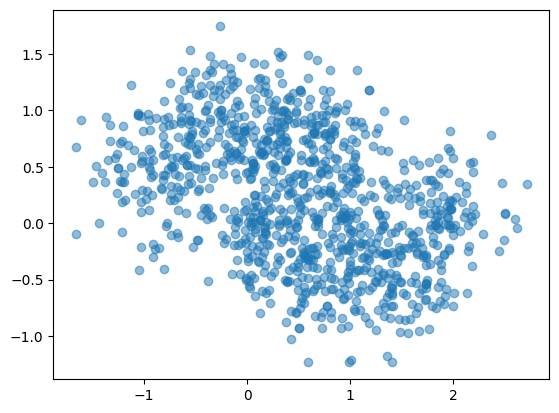

In [141]:
dataset = generate_moons(50000, noise=0.3)
batch_size=1024

idx = torch.randint(0, dataset.shape[0], (batch_size,))
x0 = dataset[idx]
print(f"{x0.shape=}")
plt.scatter(x0[:, 0], x0[:, 1], alpha=0.5)

In [34]:
print(sum(p.numel() for p in ddpm.model.parameters()))

17282


In [15]:
torch.save(dataset, "dataset.pt")

In [4]:
# trying with a bigger MLP

def mlp(in_dim, hidden_dim, out_dim):

    return nn.Sequential(
        nn.Linear(in_dim+1, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 2*  hidden_dim),
        nn.ReLU(),
        nn.Linear(2*hidden_dim, 2*  hidden_dim),
        nn.ReLU(),
        nn.Linear(2*hidden_dim, out_dim)
    )
    


In [6]:
mlp_model = mlp(2,128, 2)
print(sum(p.numel() for p in mlp_model.parameters()))

99842


In [9]:
dataset = generate_moons(50000, noise=0.01)

Epoch 0, Loss: 0.8850
Epoch 500, Loss: 0.5216
Epoch 1000, Loss: 0.5560
Epoch 1500, Loss: 0.5008
Epoch 2000, Loss: 0.4800
Epoch 2500, Loss: 0.5917
Epoch 3000, Loss: 0.5259
Epoch 3500, Loss: 0.4768
Epoch 4000, Loss: 0.4921
Epoch 4500, Loss: 0.5300


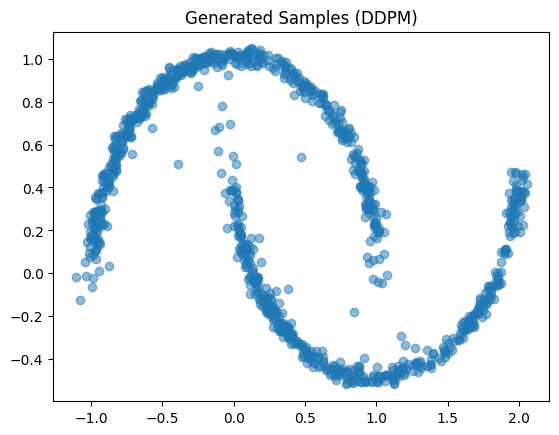

In [12]:
mlp_model = mlp(2,128, 2)
ddpm = DDPM(T=100, mlp_model=mlp_model)
train_ddpm(ddpm, epochs=5000, batch_size=128, lr=1e-3, n_samples=1000, noise_dataset=0.01, dataset=dataset)
samples = ddpm.sample()
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title("Generated Samples (DDPM)")
plt.show()

In [13]:
torch.save(ddpm, "ddpm.pt")

In [14]:
m = torch.load("ddpm.pt")

C:\Users\gabri\AppData\Local\Temp\ipykernel_28160\2140492650.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m = torch.load("ddpm.pt")


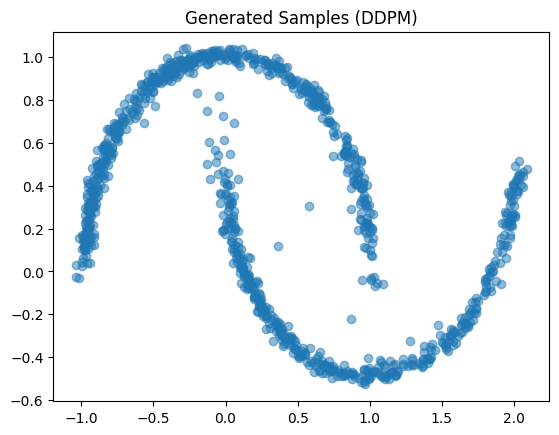

In [16]:

samples = ddpm.sample()
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title("Generated Samples (DDPM)")
plt.show()

## Consistency model training with distillation diffusion

In [26]:
class ConsistencyModel(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=128, out_dim=2,dropout_prob=0.1, T=120):
        super().__init__()
        # self.model = nn.Sequential(
        #     nn.Linear(in_dim+1, hidden_dim),
        #     nn.ReLU(),
        #     nn.Dropout(p=dropout_prob),
        #     nn.Linear(hidden_dim, hidden_dim),
        #     nn.ReLU(),
        #     nn.Dropout(p=dropout_prob),
        #     nn.Linear(hidden_dim, out_dim)
        # )
        self.model= mlp(in_dim, hidden_dim, out_dim)
        self.T = T
        self.eps = 0.002
        self.input_dim = in_dim
        self.output_dim = out_dim
        self.hidden_dim=hidden_dim

    def c_skip(self, t):
        """Skip coefficient ensuring c_skip(eps) = 1."""
        return 1 - ((t- self.eps) / self.T)

    def c_out(self, t):
        """Output coefficient ensuring c_out(eps) = 0."""
        return (t - self.eps) / self.T
    
    def forward(self, x, t):
        t = t.view(-1,1) # to use broadcast
        x_t = torch.cat([x, t], dim=-1)
        f_theta = self.model(x_t)

        # Compute skip and output coefficients
        c_skip_t = self.c_skip(t)
        c_out_t = self.c_out(t)

        output = c_skip_t * x + c_out_t * f_theta
        
        return output

def cm_sample(cm, n_samples=1000):
    x = torch.randn(n_samples, 2)
    n = torch.randint(low=1, high=ddpm.T, size=(n_samples,))  
    with torch.no_grad():
        x = cm(x, n)
    return x.detach().numpy()

In [ ]:
def one_step_euler_ode_solver(ddpm_model, x, t):
    # 1. Get the predicted noise (eps) from the model at the current timestep t
    eps = ddpm_model.get_eps_from_model_batch(x, t)
    
    # 2. Compute the reverse process mean (mu) at timestep t
    mu = ddpm_model.compute_mu_batch( x, eps, t)
    # 3. Sample random noise for the reverse diffusion step (except at t=0)
    # print(f"{t.shape=}")
    batch_size, out_dim = x.shape
    z = torch.randn((batch_size, out_dim), device=ddpm_model.device) * (t > 0).float().view(-1, 1)
    # 4. Perform the Euler update: x_t = mu_t + sqrt(beta(t)) * z
    t = t.long()
    betas_t = ddpm_model.betas[t.long()].view(-1, 1)
    x_t_minus_1 = mu + torch.sqrt(betas_t) * z
    
    return x_t_minus_1

def compute_score_function(ddpm, xt, t):
    """ Computes the score function s_phi(x_t, t) """
    t = t.long()
    eps = ddpm.get_eps_from_model_batch(xt, t)
    std = tord.sqrt(ddpm.betas[t].view(-1, 1))
    
    score = -eps / std
    return score

def compute_x_hat(ddpm, x_tn1, t_n, t_n1):
    """
    Computes the consistency update rule:
    x̂_tn = x_t(n+1) - (t_n - t_n1) * t_n1 * s_phi(x_t(n+1), t_n1)
    """
    t_n = t_n.long()
    t_n1 = t_n1.long()

    # Compute score function s_phi(x_t(n+1), t_n1)
    score_tn1 = compute_score_function(ddpm, x_tn1, t_n1)

    # Compute update step
    x_hat_tn = x_tn1 - (t_n - t_n1).view(-1, 1) * t_n1.view(-1, 1) * score_tn1

    return x_hat_tn


# def compute_mu_batch(ddpm_model, x, eps, t):
#     t = t.long()
#     self = ddpm_model
#     # Index into betas, alphas_cumprod, and alphas using the batch of timesteps t
#     betas_t = torch.tensor(self.betas[t])  # Shape: (batch_size,)
#     alphas_cumprod_t = torch.tensor(self.alphas_cumprod[t])  # Shape: (batch_size,)
#     alphas_t = torch.tensor(self.alphas[t])  # Shape: (batch_size,)
#     betas_t = betas_t.view(-1,1)
#     alphas_t = alphas_t.view(-1,1)
#     alphas_cumprod_t = alphas_cumprod_t.view(-1,1)
#     # Compute the reverse process mean (mu)
#     mu = (x - betas_t / torch.sqrt(1 - alphas_cumprod_t) * eps) / torch.sqrt(alphas_t)
#     return mu


In [10]:
def generate_samples_multistep(cm, num_samples=100, N=10, device="cpu"):
    """Generates samples from the EMA model using Multistep Consistency Sampling."""
    cm.model.eval()
    T = 1
    self = cm
    with torch.no_grad():
        # Initial noise
        e = torch.zeros((num_samples,2)).to(device)
        z =  torch.randn_like(e)

        # Sequence of time points
        tau = torch.linspace(0, T, N + 1, device=device)[1:]  # Exclude t=0

        # Initial sample
        x = z

        for n in range(N ):
            # Sample z from N(0, I)
            z = torch.randn_like(x)

            # Update x
            x_tau_n = x - (tau[n] ** 2) * z
            t_used = tau[n].expand(num_samples).view(-1, *([1] * (x.dim() - 1)))
            x = cm(x_tau_n, t_used)

    return x.cpu()

In [21]:
@torch.no_grad()
def update_ema(target_params, source_params, rate=0.99):
    """
    Update target parameters to be closer to those of source parameters using
    an exponential moving average.

    :param target_params: the target parameter sequence.
    :param source_params: the source parameter sequence.
    :param rate: the EMA rate (closer to 1 means slower).
    """
    for targ, src in zip(target_params, source_params):
        targ.detach().mul_(rate).add_(src, alpha=1 - rate)

In [5]:
def compute_time_steps(N, epsilon=2e-3, T=80, rho=7):
    """
    Compute discretized time steps following Karras et al. (2022).
    """
    return torch.tensor([
        (epsilon**(1/rho) + (i-1)/(N-1) * (T**(1/rho) - epsilon**(1/rho)))**rho
        for i in range(1, N+1)
    ])

In [7]:
time_steps = compute_time_steps(N=120)
print(time_steps)

tensor([2.0000e-03, 2.4561e-03, 2.9986e-03, 3.6407e-03, 4.3973e-03, 5.2847e-03,
        6.3215e-03, 7.5280e-03, 8.9267e-03, 1.0542e-02, 1.2403e-02, 1.4538e-02,
        1.6980e-02, 1.9766e-02, 2.2935e-02, 2.6529e-02, 3.0596e-02, 3.5187e-02,
        4.0355e-02, 4.6161e-02, 5.2669e-02, 5.9947e-02, 6.8072e-02, 7.7122e-02,
        8.7185e-02, 9.8353e-02, 1.1073e-01, 1.2441e-01, 1.3952e-01, 1.5617e-01,
        1.7450e-01, 1.9464e-01, 2.1675e-01, 2.4097e-01, 2.6748e-01, 2.9644e-01,
        3.2806e-01, 3.6252e-01, 4.0004e-01, 4.4084e-01, 4.8516e-01, 5.3324e-01,
        5.8535e-01, 6.4176e-01, 7.0278e-01, 7.6869e-01, 8.3984e-01, 9.1656e-01,
        9.9921e-01, 1.0882e+00, 1.1838e+00, 1.2866e+00, 1.3970e+00, 1.5153e+00,
        1.6421e+00, 1.7780e+00, 1.9233e+00, 2.0788e+00, 2.2448e+00, 2.4222e+00,
        2.6113e+00, 2.8130e+00, 3.0280e+00, 3.2568e+00, 3.5003e+00, 3.7593e+00,
        4.0345e+00, 4.3268e+00, 4.6371e+00, 4.9662e+00, 5.3152e+00, 5.6850e+00,
        6.0766e+00, 6.4911e+00, 6.9296e+

In [ ]:
def train_consistency_model(ddpm, cm, epochs=5000, batch_size=128, mu=0.99, lr=1e-4, noise_dataset=0.1):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device="cpu"
    dataset = generate_moons(1000, noise= noise_dataset).to(device)
    optimizer = optim.Adam(cm.parameters(), lr)
    criterion = nn.MSELoss()
    cm_shadow = ConsistencyModel()
    cm_shadow.load_state_dict(cm.state_dict())
    cm_shadow.eval()
    cm.train()
    cm.to(device)
    cm_shadow.to(device)
    ddpm.to(device)
    cm_shadow.to(device)
    for epoch in range(epochs):
        idx = torch.randint(0, dataset.shape[0], (batch_size,))
        x0 = dataset[idx]
        n = torch.randint(low=1, high=ddpm.T-1, size=(batch_size,), device=device)         
        xt, _ = ddpm.forward_diffusion(x0, n)
     

        # with torch.no_grad():
        #     cm_target = ddpm.get_x0_from_xt(xt, n)   
        with torch.no_grad():
            #x_tn = xt + (1.0 / ddpm.T) * one_step_euler_ode_solver(ddpm, xt, n)
            x_tn = # update rule
            cm_target = cm_shadow(x_tn,n) 
    

        cm_pred = cm(xt, n+1)
        cm_pred = cm_pred.clamp(-1,2)
        loss = criterion(cm_pred, cm_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Exponential moving average 
        with torch.no_grad():
            update_ema(cm_shadow.parameters(),cm.parameters(), rate=mu)
        
        if epoch % 500 == 0:
            print(f"CM Epoch {epoch}, Loss: {loss.item():.12f}")
            # samples = cm_sample(cm)
            samples = generate_samples_multistep(cm, num_samples=1000, N=100, device=device)
            plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
            plt.ylim([-15, 15])
            plt.xlim([-15,15])
            plt.title(f"Generated Samples (Consistency Model) epoch={epoch}")
            plt.show()

In [40]:
cm = ConsistencyModel(dropout_prob=0.0)
train_consistency_model(ddpm, cm, epochs=20000, lr=1e-4, mu=0.99, noise_dataset=0.01, batch_size=128)
# samples = cm_sample(cm)
# plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
# plt.title("Generated Samples (Consistency Model)")
# plt.show()


../aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [0,0,0], thread: [35,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [0,0,0], thread: [54,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [0,0,0], thread: [29,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [15]:
samples = cm_sample(cm)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title("Generated Samples (Consistency Model)")
plt.show()

NameError: name 'cm_sample' is not defined

### nouvelle version consistency model

In [8]:
%load_ext autoreload
%autoreload 2

In [20]:
dataset =  generate_moons(n_samples=1000, noise=0.01)

Epoch 0, Loss: 0.9803
Epoch 500, Loss: 0.4770
Epoch 1000, Loss: 0.3754
Epoch 1500, Loss: 0.4821
Epoch 2000, Loss: 0.4473
Epoch 2500, Loss: 0.4141
Epoch 3000, Loss: 0.4756
Epoch 3500, Loss: 0.4622
Epoch 4000, Loss: 0.4797
Epoch 4500, Loss: 0.3588
Epoch 5000, Loss: 0.3723
Epoch 5500, Loss: 0.4337
Epoch 6000, Loss: 0.3987
Epoch 6500, Loss: 0.5082
Epoch 7000, Loss: 0.4103
Epoch 7500, Loss: 0.4032
Epoch 8000, Loss: 0.4316
Epoch 8500, Loss: 0.3720
Epoch 9000, Loss: 0.3885
Epoch 9500, Loss: 0.4579
Epoch 10000, Loss: 0.5695
Epoch 10500, Loss: 0.4924
Epoch 11000, Loss: 0.3314
Epoch 11500, Loss: 0.4954
Epoch 12000, Loss: 0.5088
Epoch 12500, Loss: 0.3490
Epoch 13000, Loss: 0.3929
Epoch 13500, Loss: 0.5024
Epoch 14000, Loss: 0.4561
Epoch 14500, Loss: 0.3932
Epoch 15000, Loss: 0.4484
Epoch 15500, Loss: 0.4116
Epoch 16000, Loss: 0.5278
Epoch 16500, Loss: 0.3245
Epoch 17000, Loss: 0.5190
Epoch 17500, Loss: 0.4027
Epoch 18000, Loss: 0.3861
Epoch 18500, Loss: 0.4434
Epoch 19000, Loss: 0.4190
Epoch 1950

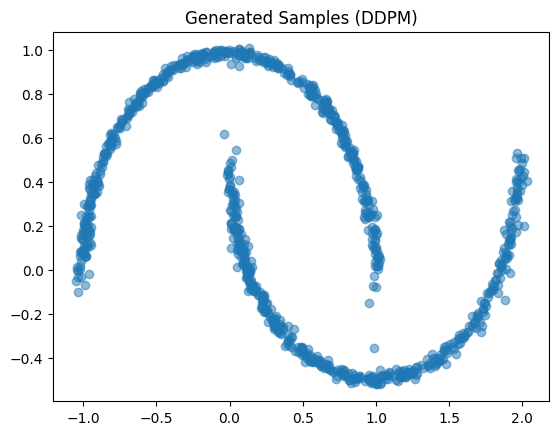

In [21]:
mlp_model = mlp(2,128, 2)
ddpm = DDPM(T=120, mlp_model=mlp_model)
train_ddpm(ddpm, dataset=dataset, epochs=20000, batch_size=128, lr=1e-3, n_samples=5000, noise_dataset=0.01)
samples = ddpm.sample()
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title("Generated Samples (DDPM)")
plt.show()

In [92]:

def multistep_consistency_sampling(cm, N, n_samples=1000, device="cuda"):
    """
    Multistep Consistency Sampling algorithm for multiple samples.
    
    Args:
        cm: Trained consistency model.
        N: Number of time steps.
        n_samples: Number of samples to generate.
        device: Computation device.
    
    Returns:
        Sampled data from the model.
    """
    with torch.no_grad():
        time_steps = torch.flip(compute_time_steps(N).to(device), dims=[0])  # Reverse the time steps
        x = torch.randn(n_samples, cm.input_dim, device=device)  # Initial noise samples
        
        # Ensure time_steps[0] has the same batch size as x
        t = time_steps[0].expand(n_samples)
        x = cm(x, t)  # Initial denoising step at t = T
        stds = [torch.sqrt(tau_n**2 - time_steps[-1]**2) for tau_n in time_steps]
        for n in range(N - 1):
            z = torch.randn_like(x, device=device)  # Gaussian noise sample
            # print(f"{z}")
            tau_n = time_steps[n]
            # print(f"{tau_n=}")
            x_hat_tau_n = x + stds[n] * z
            # print(f"{(torch.sqrt(tau_n**2 - time_steps[-1]**2) * z)=}")
            # print(f"{x_hat_tau_n=}")
            x = cm(x_hat_tau_n, tau_n.expand(n_samples) )
            # print(f"{x=}")
    
    return x.cpu()

In [78]:
time_steps = torch.flip(compute_time_steps(N=120).to("cuda"), dims=[0])

In [80]:
[torch.sqrt(tau_n**2 - time_steps[-1]**2) for tau_n in time_steps]

[tensor(80., device='cuda:0'),
 tensor(76.4011, device='cuda:0'),
 tensor(72.9419, device='cuda:0'),
 tensor(69.6179, device='cuda:0'),
 tensor(66.4245, device='cuda:0'),
 tensor(63.3575, device='cuda:0'),
 tensor(60.4127, device='cuda:0'),
 tensor(57.5860, device='cuda:0'),
 tensor(54.8734, device='cuda:0'),
 tensor(52.2711, device='cuda:0'),
 tensor(49.7753, device='cuda:0'),
 tensor(47.3824, device='cuda:0'),
 tensor(45.0887, device='cuda:0'),
 tensor(42.8909, device='cuda:0'),
 tensor(40.7856, device='cuda:0'),
 tensor(38.7694, device='cuda:0'),
 tensor(36.8393, device='cuda:0'),
 tensor(34.9922, device='cuda:0'),
 tensor(33.2250, device='cuda:0'),
 tensor(31.5349, device='cuda:0'),
 tensor(29.9190, device='cuda:0'),
 tensor(28.3746, device='cuda:0'),
 tensor(26.8990, device='cuda:0'),
 tensor(25.4897, device='cuda:0'),
 tensor(24.1442, device='cuda:0'),
 tensor(22.8600, device='cuda:0'),
 tensor(21.6349, device='cuda:0'),
 tensor(20.4664, device='cuda:0'),
 tensor(19.3525, device=

In [70]:
def compute_score_function(ddpm, xt, t):
    """ Computes the score function s_phi(x_t, t) """
    t = t.long()
    eps = ddpm.get_eps_from_model_batch(xt, t)
    std = torch.sqrt(ddpm.betas[t].view(-1, 1))
    
    score = -eps / std
    return score

def compute_x_hat(ddpm, x_tn1, t_n, t_n1):
    """
    Computes the consistency update rule:
    x̂_tn = x_t(n+1) - (t_n - t_n1) * t_n1 * s_phi(x_t(n+1), t_n1)
    """
    t_n = t_n.long()
    t_n1 = t_n1.long()

    # Compute score function s_phi(x_t(n+1), t_n1)
    score_tn1 = compute_score_function(ddpm, x_tn1, t_n1)

    # Compute update step
    x_hat_tn = x_tn1 - (t_n - t_n1).view(-1, 1) * t_n1.view(-1, 1) * score_tn1

    return x_hat_tn


In [110]:
def consistency_distillation(cd_model, ddpm, dataset, epochs=5000, batch_size=128, lr=1e-4, mu=0.99, N=120, log_every=500):
    """
    Train a consistency model using Consistency Distillation (CD) algorithm.
    
    Args:
        cd_model: The consistency model to be trained.
        dataset: The training dataset.
        epochs: Number of training iterations.
        batch_size: Number of samples per batch.
        lr: Learning rate for optimization.
        mu: EMA update rate for shadow model.
        N: Number of discrete timesteps.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    optimizer = optim.Adam(cd_model.parameters(), lr=lr)
    criterion = nn.MSELoss()  # Define distance function d(·,·)
    
    # Compute discretized time steps
    time_steps = compute_time_steps(N).to(device)
    
    # Shadow model for exponential moving average (EMA)
    cd_model_shadow = ConsistencyModel()
    cd_model_shadow.load_state_dict(cd_model.state_dict())
    cd_model_shadow.eval()
    
    cd_model.to(device)
    cd_model_shadow.to(device)
    
    for epoch in range(epochs):
        cd_model.train()
        cd_model_shadow.eval()
        idx = torch.randint(0, dataset.shape[0], (batch_size,))
        x = dataset[idx].to(device)
        
        # Sample index from precomputed time steps
        n_idx = torch.randint(0, N-1, (batch_size,), device=device)
        t_n = time_steps[n_idx]
        t_n1 = time_steps[n_idx + 1]  # Ensure t_n1 > t_n
        
        # Sample x_{t_{n+1}} ~ N(x; t_{n+1}^2 I)
        noise = torch.randn_like(x)
        x_tn1 = x + (t_n1.view(-1, 1)) * noise
        
        # Compute x̂_{t_n} using the update rule
        with torch.no_grad():
            x_hat_tn = compute_x_hat(ddpm, x_tn1, t_n, t_n1)
            
            # Compute the target f_{\theta^-}(x̂_{t_n}, t_n)
            cm_target = cd_model_shadow(x_hat_tn, t_n)
        
        # Model prediction f_θ(x_{t_{n+1}}, t_{n+1})
        cm_pred = cd_model(x_tn1, t_n1)
        
        # Compute weighted loss \lambda(t_n) * d(f_θ(x_{t_{n+1}}, t_{n+1}), f_{θ^-}(x̂_{t_n}, t_n))
        # lambda_tn = (t_n / time_steps[-1]).view(-1, 1)  # Example weight function
        lambda_tn = 1
        loss = (lambda_tn * criterion(cm_pred, cm_target)).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # EMA update for shadow model
        with torch.no_grad():
            for param, shadow_param in zip(cd_model.parameters(), cd_model_shadow.parameters()):
                shadow_param.data = mu * shadow_param.data + (1 - mu) * param.data
        
        if epoch % log_every == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
            samples =  multistep_consistency_sampling(cd_model, N, n_samples=1000, device="cuda").numpy()
            # print(f"{samples.shape=}")
            # print(samples)
            plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1)
            plt.title(f"Generated Samples (Consistency Model) epoch={epoch}")
            plt.show()


Epoch 0, Loss: 1669918464.000000


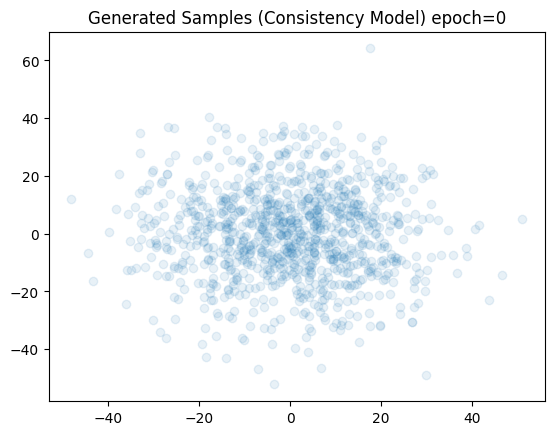

Epoch 1000, Loss: 4172073984.000000


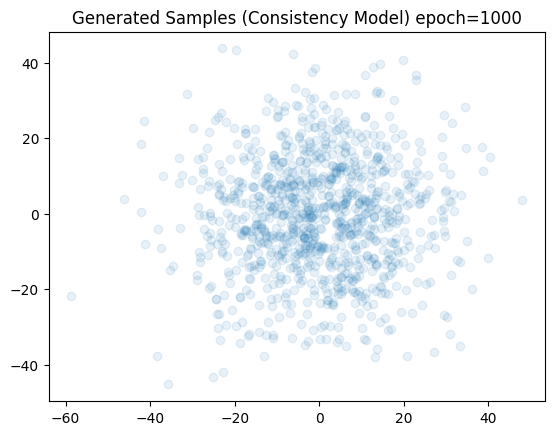

Epoch 2000, Loss: 5338443264.000000


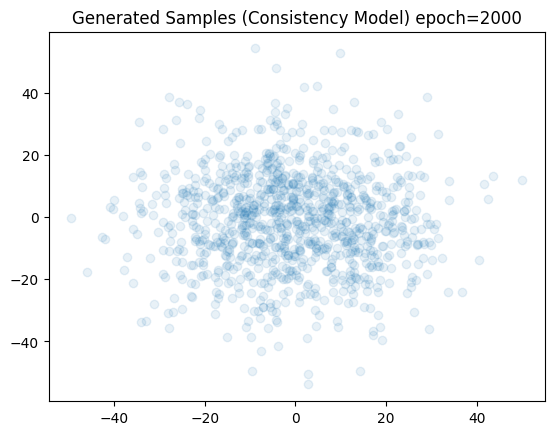

Epoch 3000, Loss: 1428972672.000000


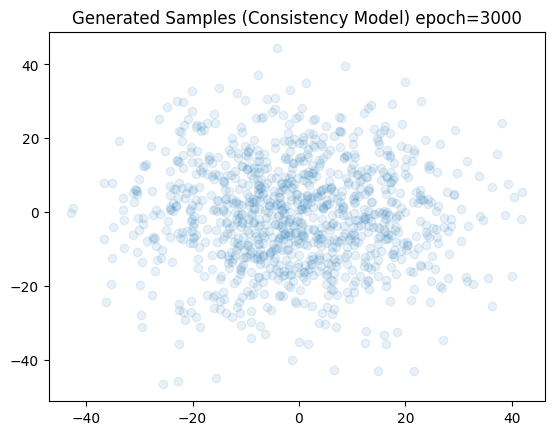

Epoch 4000, Loss: 4571819520.000000


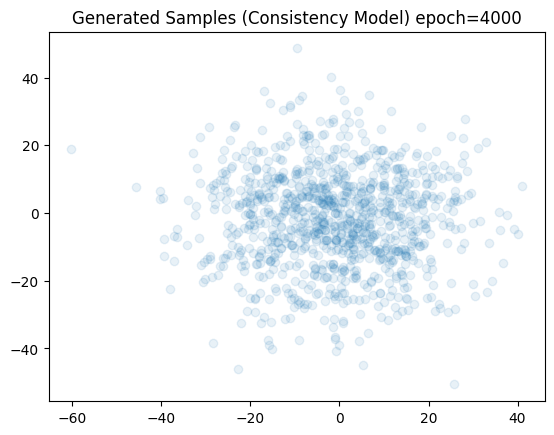

Epoch 5000, Loss: 1651286784.000000


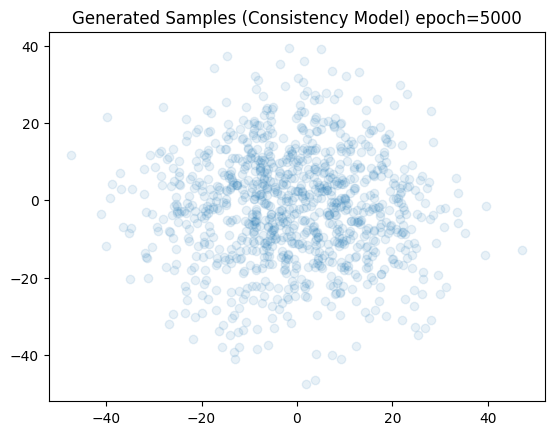

Epoch 6000, Loss: 4727057920.000000


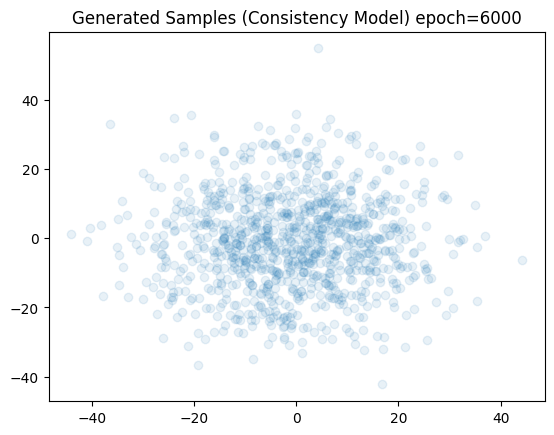

Epoch 7000, Loss: 3255913472.000000


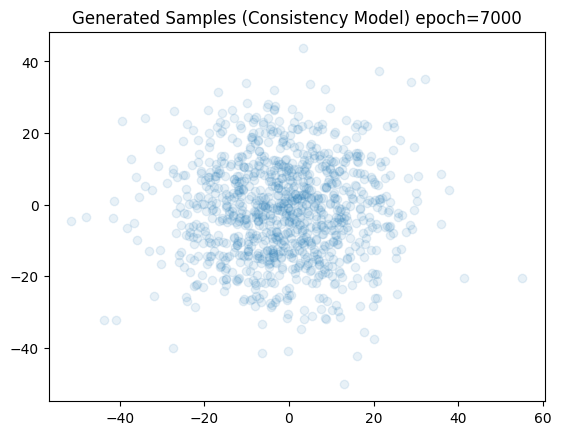

Epoch 8000, Loss: 4333092864.000000


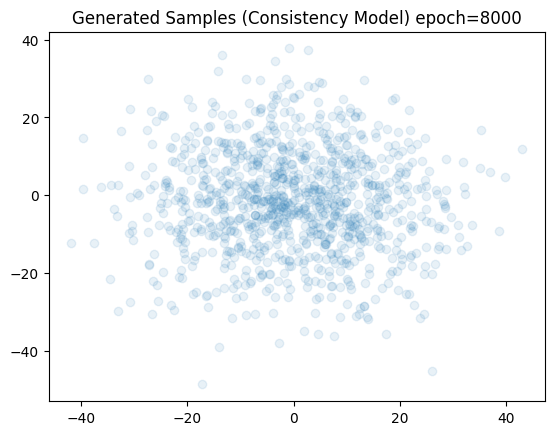

Epoch 9000, Loss: 2318708480.000000


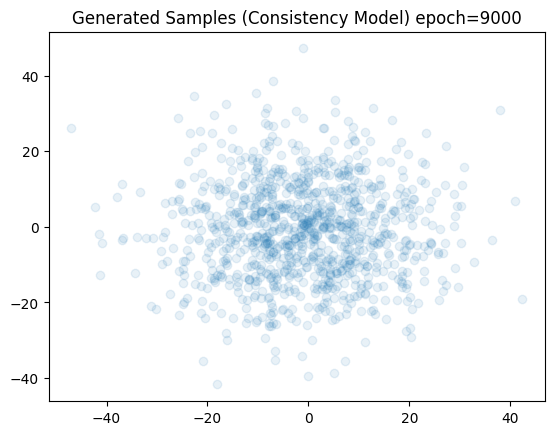

Epoch 10000, Loss: 3968580608.000000


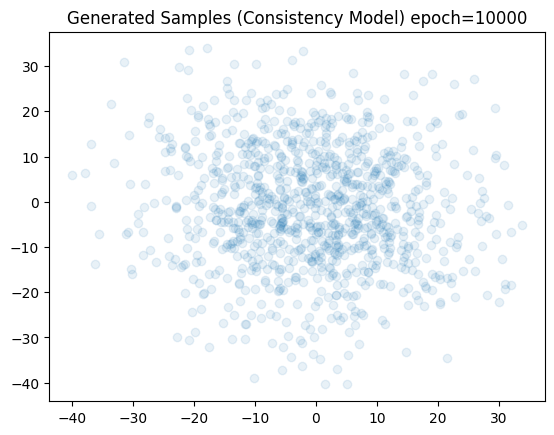

Epoch 11000, Loss: 1721470464.000000


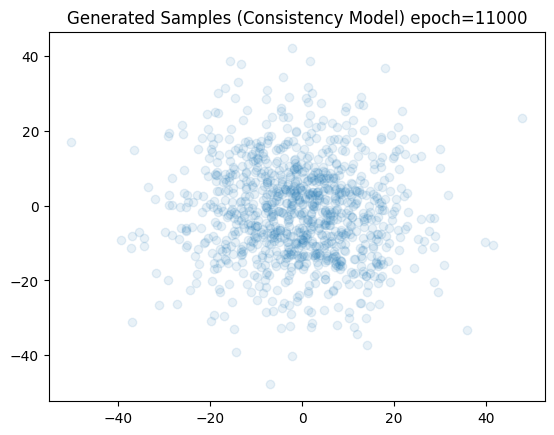

Epoch 12000, Loss: 2156987136.000000


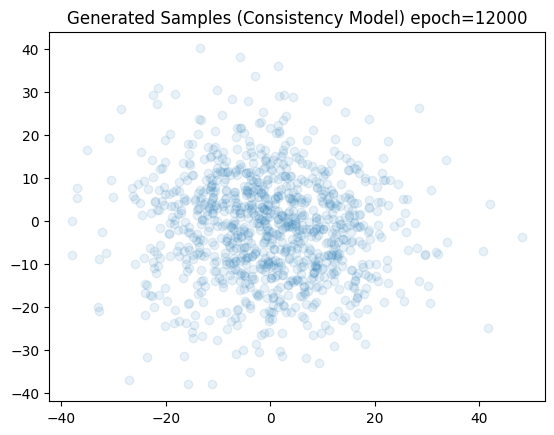

Epoch 13000, Loss: 1932597504.000000


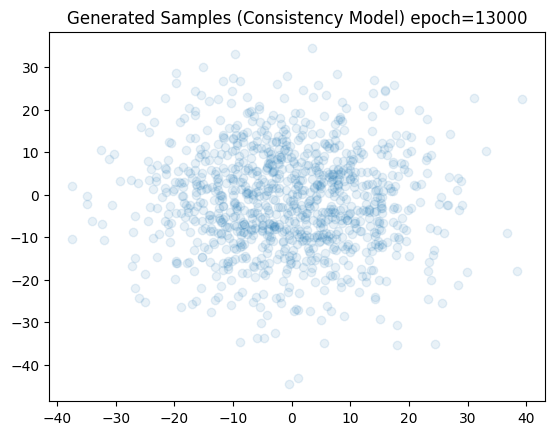

Epoch 14000, Loss: 2875417088.000000


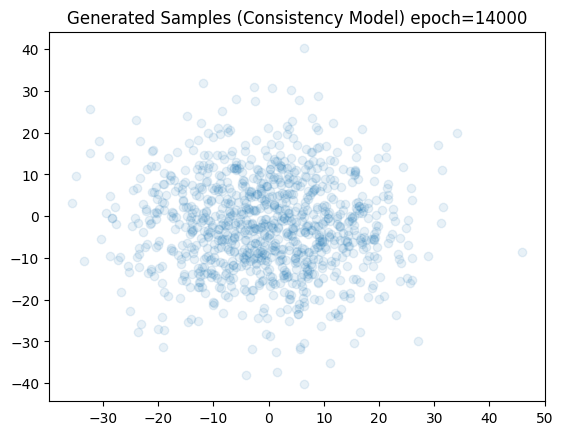

Epoch 15000, Loss: 1167309568.000000


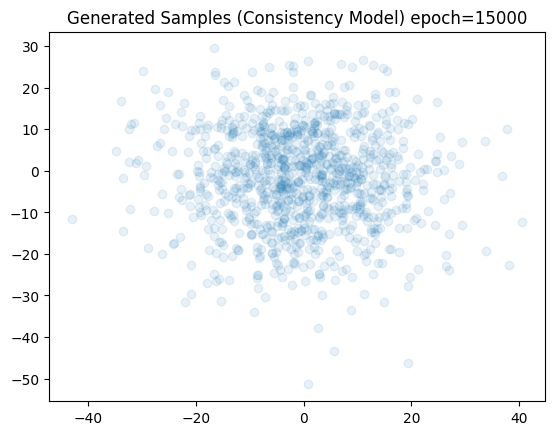

Epoch 16000, Loss: 2013156864.000000


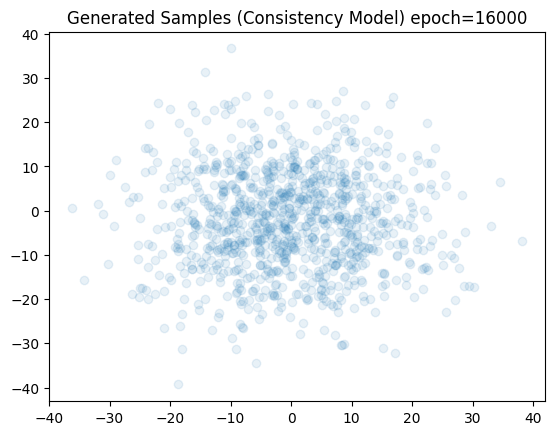

Epoch 17000, Loss: 1549257216.000000


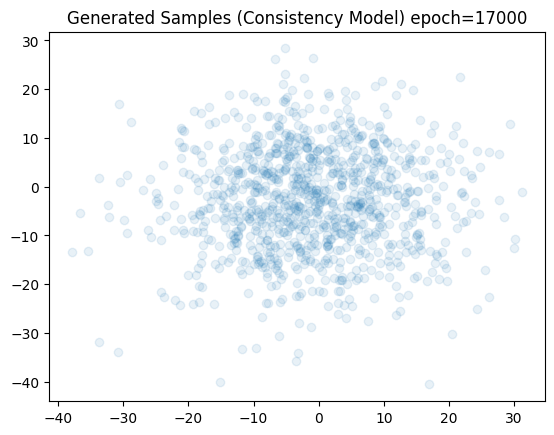

Epoch 18000, Loss: 614985920.000000


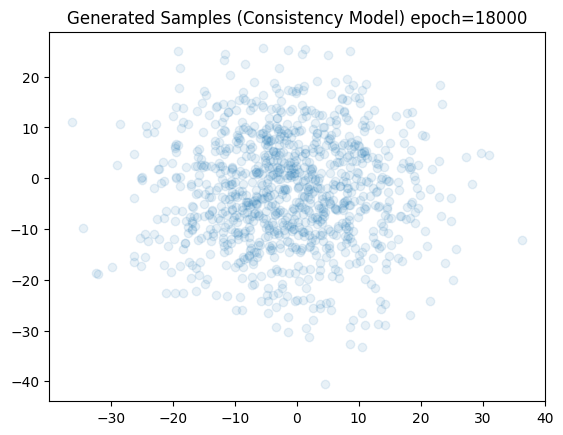

Epoch 19000, Loss: 1382179584.000000


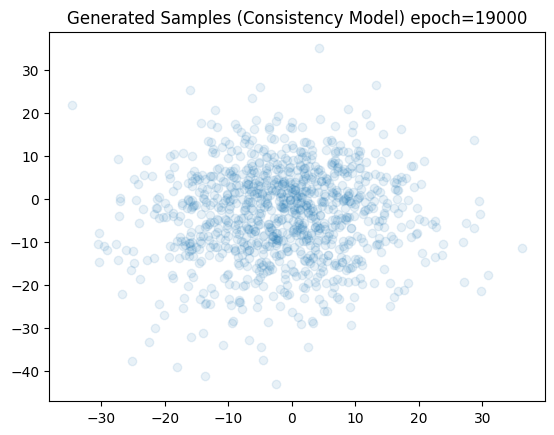

Epoch 20000, Loss: 1042078464.000000


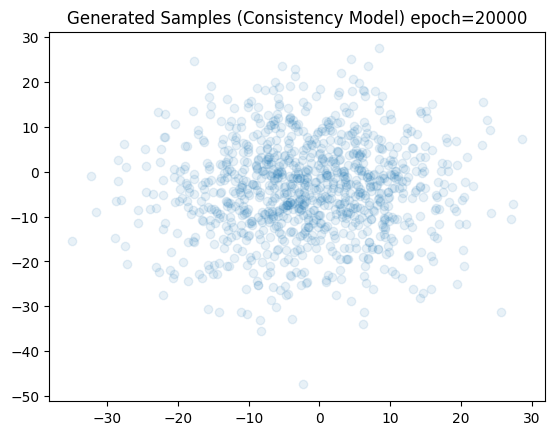

Epoch 21000, Loss: 2402925568.000000


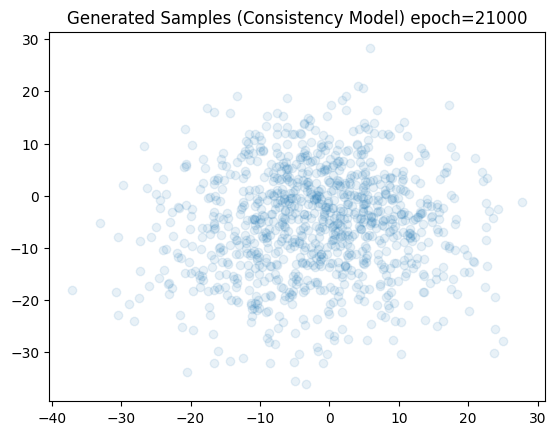

Epoch 22000, Loss: 1043986688.000000


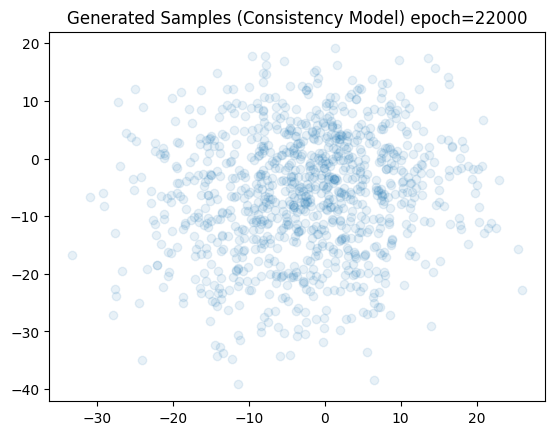

Epoch 23000, Loss: 2407624192.000000


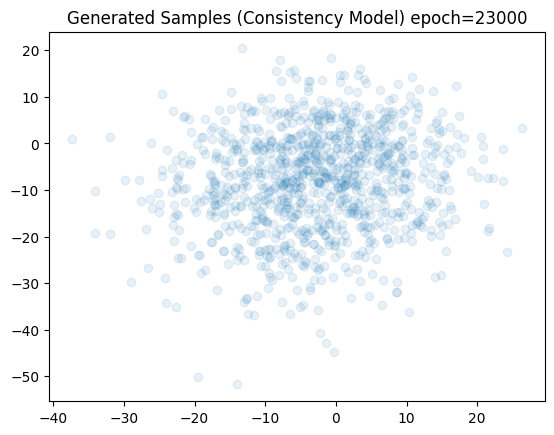

Epoch 24000, Loss: 3540510208.000000


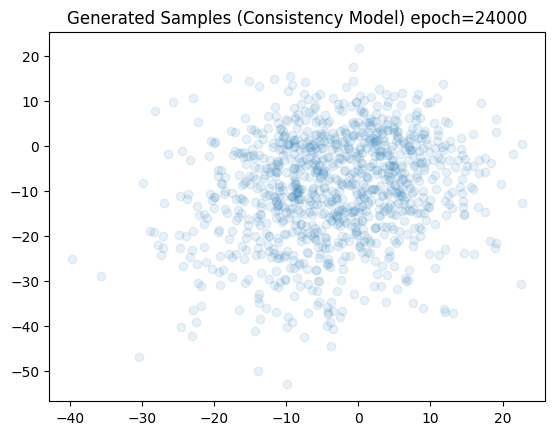

Epoch 25000, Loss: 2874602240.000000


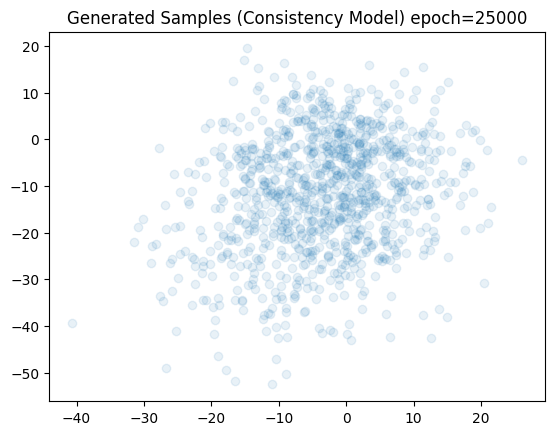

Epoch 26000, Loss: 1528927488.000000


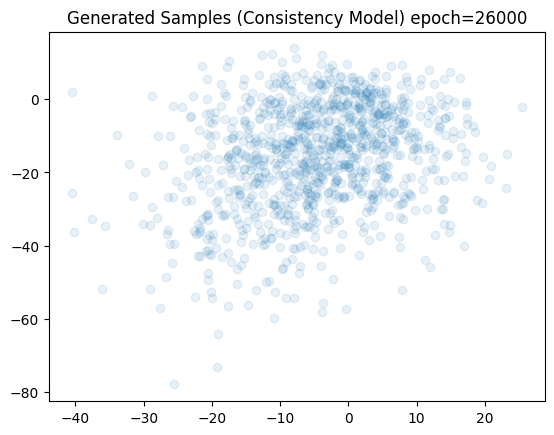

Epoch 27000, Loss: 1990057856.000000


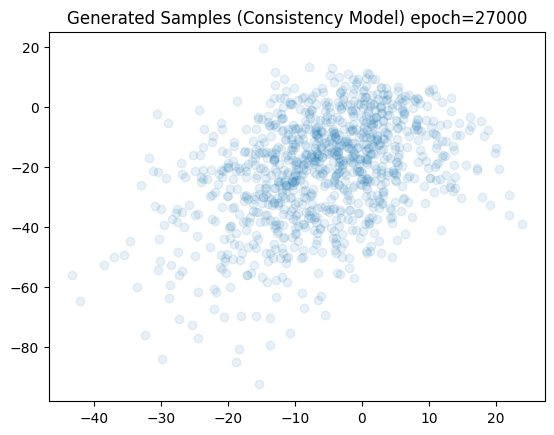

Epoch 28000, Loss: 18646790144.000000


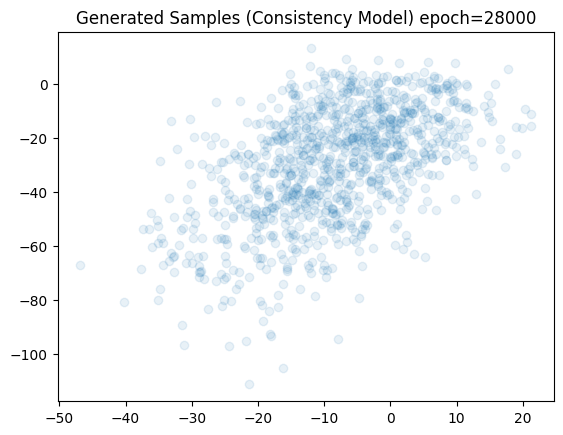

Epoch 29000, Loss: 16103618560.000000


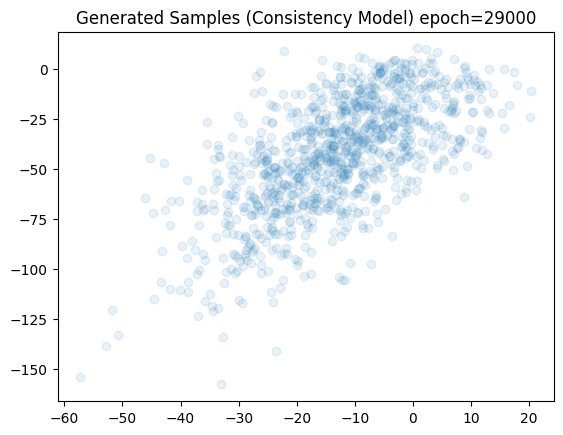

Epoch 30000, Loss: 6720798720.000000


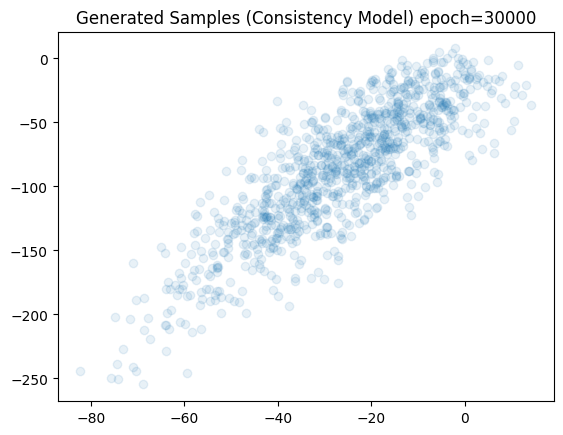

Epoch 31000, Loss: 11185766400.000000


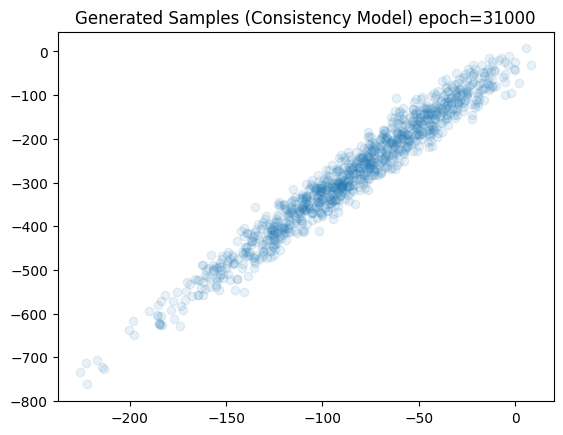

Epoch 32000, Loss: 29336088576.000000


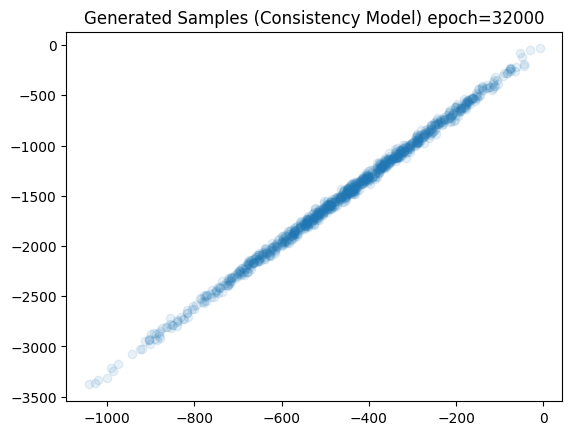

Epoch 33000, Loss: 32629178368.000000


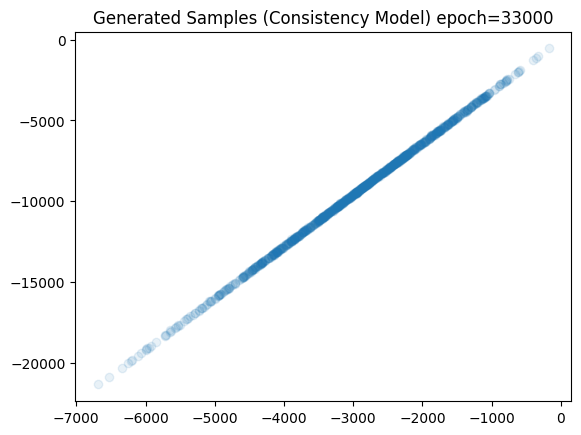

Epoch 34000, Loss: 8309893120.000000


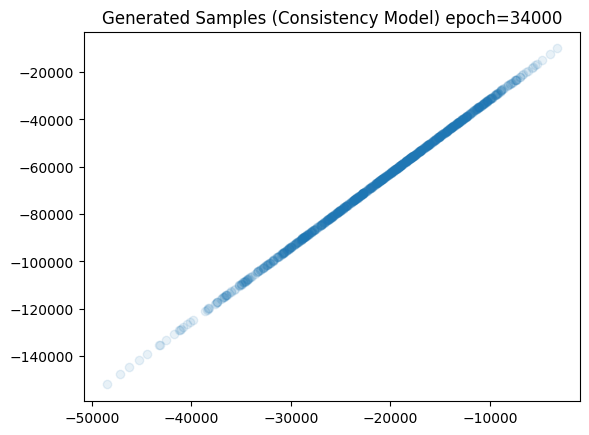

In [ ]:
cd_model = ConsistencyModel()
consistency_distillation(cd_model, ddpm, dataset, epochs=100000, batch_size=128, lr=5e-7, mu=0.99, N=120, log_every=1000)

## Datasets

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [17]:
from sklearn.datasets import make_regression
x,y = make_regression(n_samples=1000, n_features=1, n_targets=1, bias=1, noise=0.01)
dataset = dataset.astype(np.float32)



In [15]:
dataset.shape

(1000, 2)

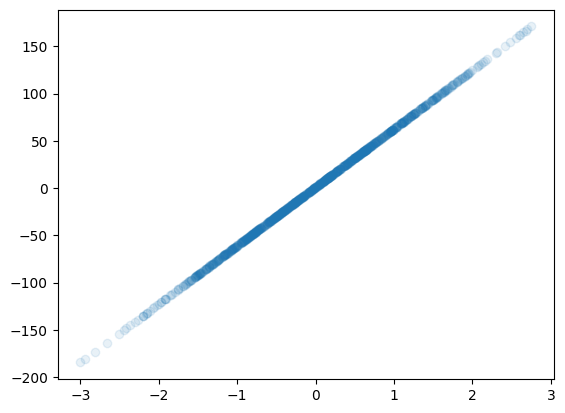

In [18]:
plt.scatter(x,y, alpha=0.1
            )
plt.show()

In [9]:
from line_dataset import LineDataset
import torch
x = torch.Tensor([1,1])
y = torch.Tensor([2,2])
dataset = LineDataset(1000,x,y)

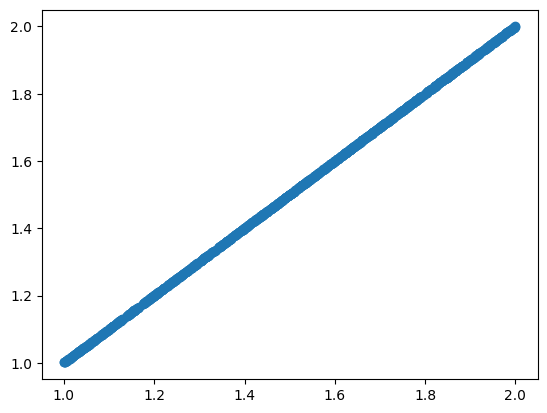

In [5]:
plt.scatter(dataset.data[:,0], dataset.data[:,1])
plt.show()

In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
from Distillation import DDPM, ConsistencyModel, train_ddpm, consistency_distillation

ddpm_line = DDPM(hidden_dim=32, T=100 )
train_ddpm(ddpm_line, dataset=dataset, epochs=50000, batch_size=128, log_every=1000, lr=1e-2)

Epoch 0, Loss: 0.9486
Epoch 1000, Loss: 0.0105
Epoch 2000, Loss: 0.0210
Epoch 3000, Loss: 0.0272
Epoch 4000, Loss: 0.0545
Epoch 5000, Loss: 0.0156
Epoch 6000, Loss: 0.0150
Epoch 7000, Loss: 0.0236
Epoch 8000, Loss: 0.0117
Epoch 9000, Loss: 0.0180
Epoch 10000, Loss: 0.0206
Epoch 11000, Loss: 0.0234
Epoch 12000, Loss: 0.0163
Epoch 13000, Loss: 0.0248
Epoch 14000, Loss: 0.0145
Epoch 15000, Loss: 0.0231
Epoch 16000, Loss: 0.0082
Epoch 17000, Loss: 0.0199
Epoch 18000, Loss: 0.0095
Epoch 19000, Loss: 0.0476
Epoch 20000, Loss: 0.0084
Epoch 21000, Loss: 0.0498
Epoch 22000, Loss: 0.0131
Epoch 23000, Loss: 0.0112
Epoch 24000, Loss: 0.0244
Epoch 25000, Loss: 0.0108
Epoch 26000, Loss: 0.0234
Epoch 27000, Loss: 0.0113
Epoch 28000, Loss: 0.0424
Epoch 29000, Loss: 0.0071
Epoch 30000, Loss: 0.0099
Epoch 31000, Loss: 0.0192
Epoch 32000, Loss: 0.0135
Epoch 33000, Loss: 0.0442
Epoch 34000, Loss: 0.0133
Epoch 35000, Loss: 0.0365
Epoch 36000, Loss: 0.0136
Epoch 37000, Loss: 0.0197
Epoch 38000, Loss: 0.0105

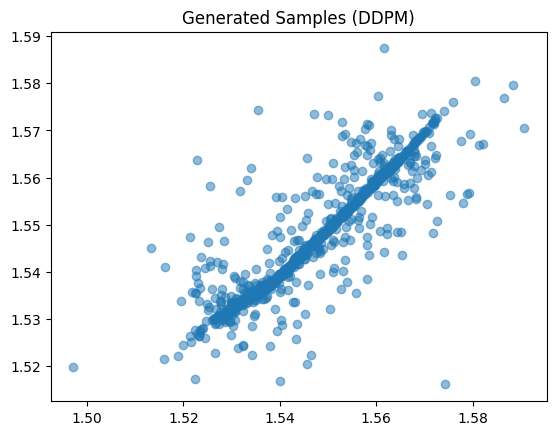

In [24]:
samples = ddpm_line.sample()
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title("Generated Samples (DDPM)")
plt.show()